In [1]:
# adding libraries
from matplotlib import pyplot as plt
import math
import numpy as np
import os
import pandas as pd
import random
import time

import cntk as C
%matplotlib inline

In [2]:
# to make things reproduceable, seed random
np.random.seed(0)
C.cntk_py.set_fixed_random_seed(1)
C.cntk_py.force_deterministic_algorithms()

In [3]:
# adding .csv files from url and read it
url="https://www.cntk.ai/jup/dat/solar.csv"
df=pd.read_csv(url, index_col="time", parse_dates=['time'], dtype=np.float32)
df["date"] = df.index.date

In [4]:
# normalizing
normalize = df['solar.total'].max()
df['solar.current'] /= normalize
df['solar.total'] /= normalize

In [5]:
# group by day, find the max for a day and add a new column .max
grouped = df.groupby(df.index.date).max()
grouped.columns = ["solar.current.max", "solar.total.max", "date"]

# merge continuous readings and daily max values into a single frame
df_merged = pd.merge(df, grouped, right_index=True, on="date")
df_merged = df_merged[["solar.current", "solar.total",
                       "solar.current.max", "solar.total.max"]]
# we group by day so we can process a day at a time.
grouped = df_merged.groupby(df_merged.index.date)
per_day = []
for _, group in grouped:
    per_day.append(group)

In [6]:
val_size=0.1 # spliting the data 10 percent for validation 
test_size=0.1 # 10 percent for testing
time_steps=14 # there are 14 lstm cells, 1 for each possible reading we get per day

In [7]:
# split the dataset into train, validatation and test sets on day boundaries
val_size = int(len(per_day) * val_size)
test_size = int(len(per_day) * test_size)
next_val = 0
next_test = 0

result_x = {"train": [], "val": [], "test": []}
result_y = {"train": [], "val": [], "test": []}    

# generate sequences a day at a time
for i, day in enumerate(per_day):
    # if we have less than 8 datapoints for a day we skip over the
    # day assuming something is missing in the raw data
    total = day["solar.total"].values
    if len(total) < 8:
        continue
    if i >= next_val:
        current_set = "val"
        next_val = i + int(len(per_day) / val_size)
    elif i >= next_test:
        current_set = "test"
        next_test = i + int(len(per_day) / test_size)
    else:
        current_set = "train"
    max_total_for_day = np.array(day["solar.total.max"].values[0])
    for j in range(2, len(total)):
        result_x[current_set].append(total[0:j])
        result_y[current_set].append([max_total_for_day])
        if j >= time_steps:
            break
# make result_y a numpy array
for ds in ["train", "val", "test"]:
    result_y[ds] = np.array(result_y[ds])
X = result_x
Y = result_y

In [8]:
# process batches of 10 days
BATCH_SIZE = time_steps * 10

def next_batch(x, y, ds):
    """get the next batch for training"""

    def as_batch(data, start, count):
        return data[start:start + count]

    for i in range(0, len(x[ds]), BATCH_SIZE):
        yield as_batch(X[ds], i, BATCH_SIZE), as_batch(Y[ds], i, BATCH_SIZE)

In [9]:
#Define the size of the internal state
H_DIMS = 14               
def create_model(x):
    """Create the model for time series prediction"""
    with C.layers.default_options(initial_state = 0.1):
        m = C.layers.Recurrence(C.layers.LSTM(H_DIMS))(x)
        m = C.sequence.last(m)
        m = C.layers.Dropout(0.2)(m)
        m = C.layers.Dense(1)(m)
        return m

In [10]:
# input sequences
x = C.sequence.input_variable(1)

# create the model
z = create_model(x)

# expected output (label), also the dynamic axes of the model output
# is specified as the model of the label input
l = C.input_variable(1, dynamic_axes=z.dynamic_axes, name="y")

# the learning rate
learning_rate = 0.005
lr_schedule = C.learning_rate_schedule(learning_rate, C.UnitType.minibatch)

# loss and error function
loss = C.squared_error(z, l)
error = C.squared_error(z, l)

# use adam optimizer
momentum_time_constant = C.momentum_as_time_constant_schedule(BATCH_SIZE / -math.log(0.9)) 
learner = C.fsadagrad(z.parameters, 
                      lr = lr_schedule, 
                      momentum = momentum_time_constant)

trainer = C.Trainer(z, (loss, error), [learner])

In [11]:
# training
loss_summary = []
EPOCHS=2000
start = time.time()
for epoch in range(0, EPOCHS):
    for x_batch, l_batch in next_batch(X, Y, "train"):
        trainer.train_minibatch({x: x_batch, l: l_batch})
        
    if epoch % (EPOCHS / 10) == 0:
        training_loss = trainer.previous_minibatch_loss_average
        loss_summary.append(training_loss)
        print("epoch: {}, loss: {:.4f}".format(epoch, training_loss))

print("Training took {:.1f} sec".format(time.time() - start))

epoch: 0, loss: 0.1263
epoch: 200, loss: 0.0076
epoch: 400, loss: 0.0081
epoch: 600, loss: 0.0092
epoch: 800, loss: 0.0078
epoch: 1000, loss: 0.0080
epoch: 1200, loss: 0.0072
epoch: 1400, loss: 0.0073
epoch: 1600, loss: 0.0072
epoch: 1800, loss: 0.0084
Training took 39612.8 sec


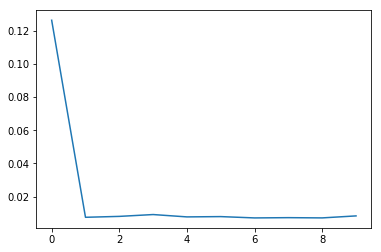

In [12]:
plt.plot(loss_summary, label='training loss');

In [13]:
# evaluate the specified X and Y data on our model
def get_error(X,Y,labeltxt):
    result = 0.0
    numbatches = 0
    for x1, y1 in next_batch(X, Y, labeltxt):
        eval_error = trainer.test_minibatch({x : x1, l : y1})
        result += eval_error
        numbatches += 1

    return float(result)/numbatches

In [14]:
# Print the training and validation errors
for labeltxt in ["train", "val"]:
    print("Error for {}: {:.8f}".format(labeltxt, get_error(X, Y, labeltxt)))

Error for train: 0.00732638
Error for val: 0.00626817


In [15]:
# Print the test error
labeltxt = "test"
print("Error for {}: {:.8f}".format(labeltxt, get_error(X, Y, labeltxt)))

Error for test: 0.00671918


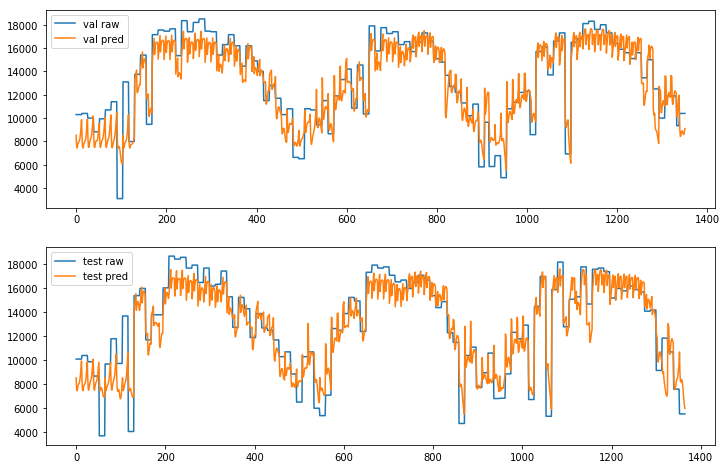

In [16]:
# predict
f, a = plt.subplots(2, 1, figsize=(12, 8))
for j, ds in enumerate(["val", "test"]):
    results = []
    for x_batch, _ in next_batch(X, Y, ds):
        pred = z.eval({x: x_batch})
        results.extend(pred[:, 0])
    # because we normalized the input data we need to multiply the prediction
    # with SCALER to get the real values.
    a[j].plot((Y[ds] * normalize).flatten(), label=ds + ' raw');
    a[j].plot(np.array(results) * normalize, label=ds + ' pred');
    a[j].legend();